# CNN Case Study 01. VGGNet

## 학습목표
> VGGNet을 직접 구현해보고 CIFAR10 데이터셋 분류 모델을 학습시켜 본다. 또한 pre-trained VGGNet을 CIFAR10 데이터셋으로 fine-tuning 하는 방법을 학습한다.


**목차(context)**
> 1. VGGNet 모델 설명
> 2. VGGNet 모델 구현
> 3. CIFAR 10 데이터 불러오기
> 4. VGGNet 모델 학습하기
> 5. Pre-trained VGGNet fine-tuning 하기

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

## VGGNet 모델 설명

> VGGNet은 3x3 사이즈의 필터로 구성된 컨볼루션 레이어를 사용한다. \
> 3x3 필터 사이즈의 컨볼루션 레이어를 두 번 거치면 receptive field가 5x5가 된다. 그리고 세번 거치면 7x7이 된다. \
> 하지만 똑같은 receptive field를 가지는 5x5 필터를 사용하면 25개의 파라미터를 학습해야 하는 것에 비해, 3x3 필터를 두번 사용하면 9+9=18개의 파라미터를 학습하면 된다. \
> 따라서 VGGNet은 파라미터 수가 더 많은 CNN모델과 비교했을 때, 같은 크기의 receptive field를 가지면서 더 적은 파라미터 수를 학습할 수 있다는 장점이 있다. \
> VGGNet은 아래 그림처럼 16개의 레이어와 19개의 레이어를 사용하는 VGG16과 VGG19의 두가지 버전이 있다. 본 실습에서는 VGG19을 구현한다.

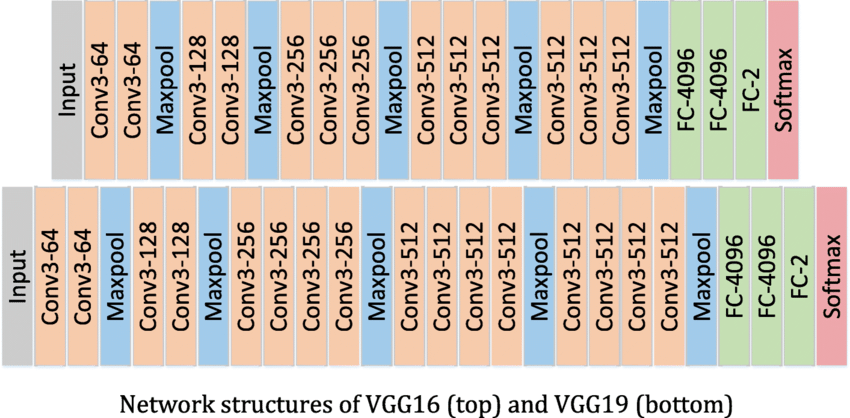

## VGGNet 모델 구현

> VGG19은 그림과 같이 3x3 필터로 구성된 컨볼루션 레이어를 연속으로 두번 적용하거나 네번 적용한 후 pooling 연산을 적용하는 구조가 반복되는 모델이다.
>
> 반복되어 사용되는 컨볼루션 레이어를 두번 거치고 풀링을 적용하는 블럭을 정의한다.

In [ ]:
# Conv Layer 2개로 구성된 ConvBlock 구현
class ConvBlock1(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(ConvBlock1, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.main = nn.Sequential(nn.Conv2d(self.in_dim, self.out_dim, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2)
                                 )

    def forward(self, x):
        out = self.main(x)
        return out

> ConvBlock1 구현의 검증을 목적으로, 더미 데이터를 만들어서 포워드 연산을 수행해 본다.

In [ ]:
conv_block = ConvBlock1(64, 128)
dummy_x = torch.randn([2,64,64,64]) # 배치크기, 채널 수, 이미지 높이, 너비(풀링 적용으로 64 -> 32)
dummy_pred = conv_block(dummy_x)
print(dummy_pred.shape)

torch.Size([2, 128, 32, 32])


> 반복되어 사용되는 컨볼루션 레이어를 네번 거치고 풀링을 적용하는 블럭을 정의한다.

In [ ]:
# Conv Layer 4개로 구성된 ConvBlock 구현
class ConvBlock2(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(ConvBlock2, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.main = nn.Sequential(nn.Conv2d(self.in_dim, self.out_dim, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),

                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),

                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),

                                  nn.Conv2d(self.out_dim, self.out_dim, kernel_size=3, padding=1),
                                  nn.BatchNorm2d(self.out_dim),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2)
                                 )

    def forward(self, x):
        out = self.main(x)
        return out

> ConvBlock2 구현의 검증을 목적으로, 더미 데이터를 만들어서 포워드 연산을 수행해 본다.

In [ ]:
conv_block = ConvBlock2(64, 128)
dummy_x = torch.randn([2,64,64,64])
dummy_pred = conv_block(dummy_x)
print(dummy_pred.shape)

torch.Size([2, 128, 32, 32])


> 위에서 정의한 두 블럭을 이용하여 VGG19를 정의한다.

In [ ]:
class VGG19(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(VGG19, self).__init__()

        self.convlayer1 = ConvBlock1(in_dim, 64)
        self.convlayer2 = ConvBlock1(64, 128)
        self.convlayer3 = ConvBlock2(128, 256)
        self.convlayer4 = ConvBlock2(256, 512)
        self.convlayer5 = ConvBlock2(512, 512)
        self.linear = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim),
        )

    def forward(self, input):
        out = self.convlayer1(input)
        out = self.convlayer2(out)
        out = self.convlayer3(out)
        out = self.convlayer4(out)
        out = self.convlayer5(out).squeeze() # batch_size x 512 x 1 x 1에서 뒤 1 x 1 축약
        out = self.linear(out)
        return out

> VGG19 모델 구현의 검증을 목적으로, 더미 데이터를 만들어서 포워드 연산을 수행해 본다.

In [ ]:
vgg19 = VGG19(3, 10)
dummy_x = torch.randn([2,3,32,32])
dummy_pred = vgg19(dummy_x)
print(dummy_pred.shape)

torch.Size([2, 10])


> 모델을 정의하고 모델의 구조를 확인한다.

## CIFAR 10 데이터 불러오기

> CIFAR10 데이터셋은 50,000개의 학습 데이터와 10,000의 테스트 데이터로 구성되어 있다.  
> 각 데이터는 10개의 클래스 중 하나에 해당한다. \
> 그리고 각 데이터의 크기는 가로 32, 세로 32의 채널 세개로 이루어져 있다. \
> CIFAR10 데이터셋은 torchvision 라이브러리에 내장되어 있다.

In [ ]:
import torchvision.datasets as datasets

def CIFAR10_DATA(root='./data/', download = True, batch_size=32, num_worker=1):
    print ("[+] Get the CIFAR10 DATA")
    train_dataset = datasets.CIFAR10(root='./data/',
                                train=True,
                                transform=transforms.ToTensor(),
                                download=True)

    test_dataset = datasets.CIFAR10(root='./data/',
                               train=False,
                               transform=transforms.ToTensor())

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False) #False
    print ("[+] Finished loading data & Preprocessing")
    return train_dataset, test_dataset, train_loader, test_loader

> 배치 사이즈를 지정하여 데이터셋과 데이터로더를 만든다.

In [ ]:
train_dataset, test_dataset, train_loader, test_loader = CIFAR10_DATA(batch_size = 32)

[+] Get the CIFAR10 DATA


100%|██████████| 170498071/170498071 [00:03<00:00, 49189818.23it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
[+] Finished loading data & Preprocessing


> CIFAR10의 예시 사진들을 확인해보기 위해 show_cifar10이라는 함수를 구현한다.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def show_cifar10(train_loader):
    images, _ = next(iter(train_loader))

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


> CIFAR10 데이터를 확인한다.

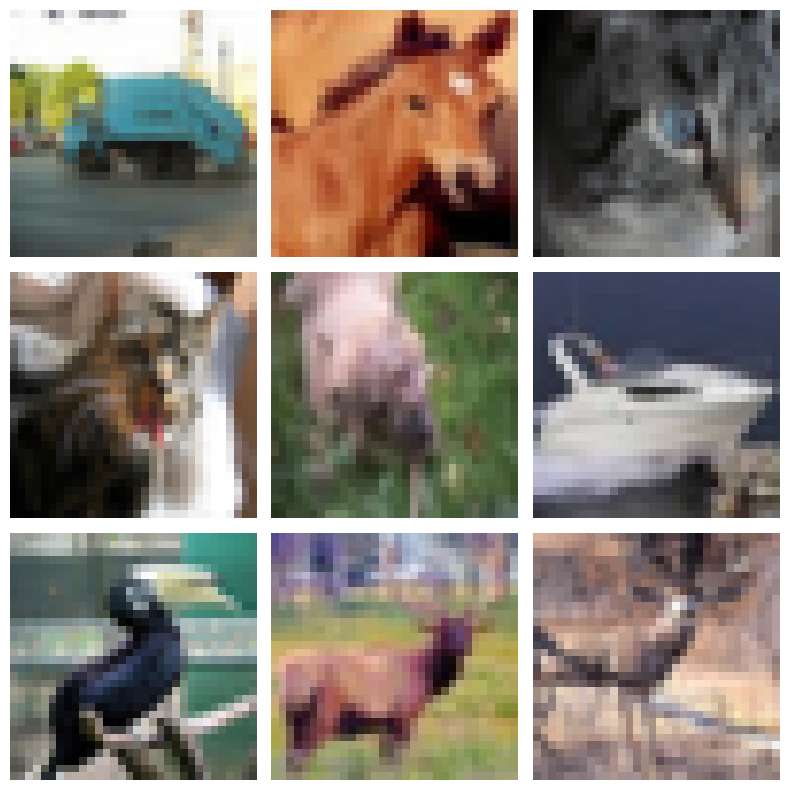

In [ ]:
show_cifar10(train_loader)

## VGGNet 모델 학습하기

> 직접 구현한 VGGNet 모델과 CIFAR-10 데이터셋을 이용하여 분류기를 학습시켜본다. \
> 학습에 앞서 세가지의 유용한 함수를 선언해준다. \
> 학습 중간에 accuracy의 값이 어떻게 변하는지를 시각화 해주는 acc_plot 함수를 구현한다.

In [ ]:
def acc_plot(acc):
    plt.plot(acc)
    plt.xlabel('log')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.show()
    return 0

> 학습이 시작한 후 시간이 얼마나 흘렀는지를 확인할 수 있는 Timer 클래스를 구현한다.

In [ ]:
import time
import datetime


class Timer():
    def __init__(self):
        self.cur_t = time.time()

    def tic(self):
        self.cur_t = time.time()

    def toc(self):
        return time.time() - self.cur_t

    def tocStr(self, t=-1):
        if (t == -1):
            return str(datetime.timedelta(seconds=np.round(time.time() - self.cur_t, 3)))[:-4]
        else:
            return str(datetime.timedelta(seconds=np.round(t, 3)))[:-4]

> 테스트 데이터로 모델의 일반화 성능을 측정하기 위한 함수를 구현한다.

In [ ]:
def test_on_cifar10(model, accuracy_list):
    model.eval()     # eval 모드로 변경 (Batch Normalization이 moving mean/var를 사용하도록, dropout을 적용하지 않도록 설정)
    correct = 0
    total = 0
    for j, (images, labels) in enumerate(test_loader):
        images = torch.tensor(images).cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
        if (j+1)%100==0:
            break

    print('Test Accuracy of the model on the 100 test images: %d %%' % (100 * correct / total))
    accuracy_list.append(100 * correct / total)
    return accuracy_list

> 하이퍼파라미터를 설정한다.

In [ ]:
batch_size = 32
learning_rate = 0.0001
num_epochs = 4

> 모델, 목적 함수, 최적화 모듈을 설정한 후 지정한 에폭 수 만큼 모델을 학습한다. \
> 이때 모델과 데이터 둘 다 cuda함수를 통해

Epoch [1/4], Iter [100/1562] Loss: 1.6278, iter_time: 4.59


<ipython-input-38-31abd6431de5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).cuda()


Test Accuracy of the model on the 100 test images: 31 %
Epoch [1/4], Iter [200/1562] Loss: 1.9748, iter_time: 4.35
Test Accuracy of the model on the 100 test images: 17 %
Epoch [1/4], Iter [300/1562] Loss: 1.5684, iter_time: 4.02
Test Accuracy of the model on the 100 test images: 27 %
Epoch [1/4], Iter [400/1562] Loss: 1.6426, iter_time: 4.01
Test Accuracy of the model on the 100 test images: 30 %
Epoch [1/4], Iter [500/1562] Loss: 1.6115, iter_time: 4.31
Test Accuracy of the model on the 100 test images: 27 %
Epoch [1/4], Iter [600/1562] Loss: 1.7832, iter_time: 5.38
Test Accuracy of the model on the 100 test images: 31 %
Epoch [1/4], Iter [700/1562] Loss: 1.6560, iter_time: 4.04
Test Accuracy of the model on the 100 test images: 33 %
Epoch [1/4], Iter [800/1562] Loss: 1.6335, iter_time: 4.03
Test Accuracy of the model on the 100 test images: 37 %
Epoch [1/4], Iter [900/1562] Loss: 1.3138, iter_time: 4.04
Test Accuracy of the model on the 100 test images: 38 %
Epoch [1/4], Iter [1000/

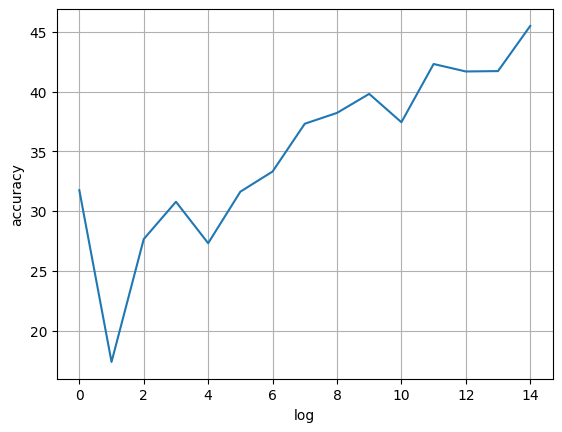

Epoch [2/4], Iter [100/1562] Loss: 1.2621, iter_time: 6.37
Test Accuracy of the model on the 100 test images: 48 %
Epoch [2/4], Iter [200/1562] Loss: 1.8462, iter_time: 4.08
Test Accuracy of the model on the 100 test images: 46 %
Epoch [2/4], Iter [300/1562] Loss: 1.3663, iter_time: 4.08
Test Accuracy of the model on the 100 test images: 47 %
Epoch [2/4], Iter [400/1562] Loss: 1.5061, iter_time: 4.30
Test Accuracy of the model on the 100 test images: 45 %
Epoch [2/4], Iter [500/1562] Loss: 1.3989, iter_time: 4.08
Test Accuracy of the model on the 100 test images: 51 %
Epoch [2/4], Iter [600/1562] Loss: 1.2315, iter_time: 4.12
Test Accuracy of the model on the 100 test images: 52 %
Epoch [2/4], Iter [700/1562] Loss: 1.2865, iter_time: 4.27
Test Accuracy of the model on the 100 test images: 51 %
Epoch [2/4], Iter [800/1562] Loss: 1.3227, iter_time: 4.11
Test Accuracy of the model on the 100 test images: 49 %
Epoch [2/4], Iter [900/1562] Loss: 0.7779, iter_time: 4.13
Test Accuracy of the 

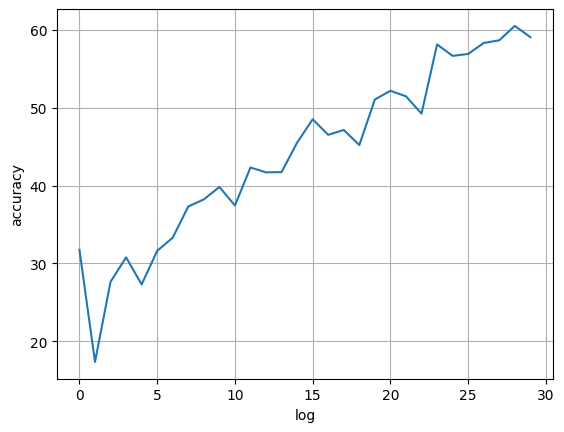

Epoch [3/4], Iter [100/1562] Loss: 1.2100, iter_time: 6.66
Test Accuracy of the model on the 100 test images: 58 %
Epoch [3/4], Iter [200/1562] Loss: 1.6013, iter_time: 4.16
Test Accuracy of the model on the 100 test images: 58 %
Epoch [3/4], Iter [300/1562] Loss: 1.2375, iter_time: 4.37
Test Accuracy of the model on the 100 test images: 60 %
Epoch [3/4], Iter [400/1562] Loss: 1.1838, iter_time: 4.20
Test Accuracy of the model on the 100 test images: 63 %
Epoch [3/4], Iter [500/1562] Loss: 0.8005, iter_time: 4.20
Test Accuracy of the model on the 100 test images: 61 %
Epoch [3/4], Iter [600/1562] Loss: 1.1819, iter_time: 4.30
Test Accuracy of the model on the 100 test images: 62 %
Epoch [3/4], Iter [700/1562] Loss: 0.9927, iter_time: 4.20
Test Accuracy of the model on the 100 test images: 64 %
Epoch [3/4], Iter [800/1562] Loss: 0.8161, iter_time: 4.25
Test Accuracy of the model on the 100 test images: 63 %
Epoch [3/4], Iter [900/1562] Loss: 0.9205, iter_time: 4.23
Test Accuracy of the 

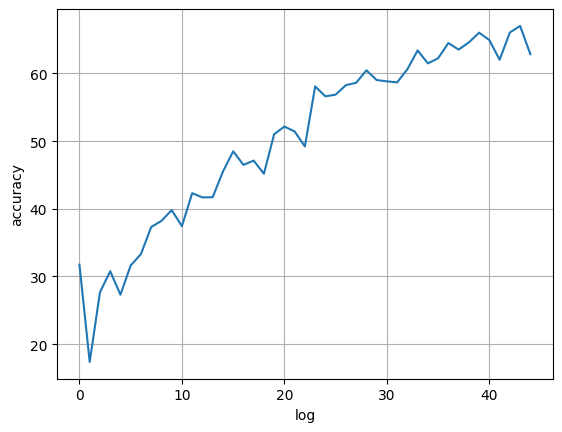

Epoch [4/4], Iter [100/1562] Loss: 0.5384, iter_time: 6.26
Test Accuracy of the model on the 100 test images: 67 %
Epoch [4/4], Iter [200/1562] Loss: 1.2029, iter_time: 4.29
Test Accuracy of the model on the 100 test images: 66 %
Epoch [4/4], Iter [300/1562] Loss: 0.9779, iter_time: 4.19
Test Accuracy of the model on the 100 test images: 67 %
Epoch [4/4], Iter [400/1562] Loss: 1.1963, iter_time: 4.20
Test Accuracy of the model on the 100 test images: 66 %
Epoch [4/4], Iter [500/1562] Loss: 0.6148, iter_time: 4.20
Test Accuracy of the model on the 100 test images: 69 %
Epoch [4/4], Iter [600/1562] Loss: 0.7087, iter_time: 4.18
Test Accuracy of the model on the 100 test images: 69 %
Epoch [4/4], Iter [700/1562] Loss: 0.9110, iter_time: 4.23
Test Accuracy of the model on the 100 test images: 70 %
Epoch [4/4], Iter [800/1562] Loss: 1.0982, iter_time: 4.20
Test Accuracy of the model on the 100 test images: 69 %
Epoch [4/4], Iter [900/1562] Loss: 0.4283, iter_time: 4.19
Test Accuracy of the 

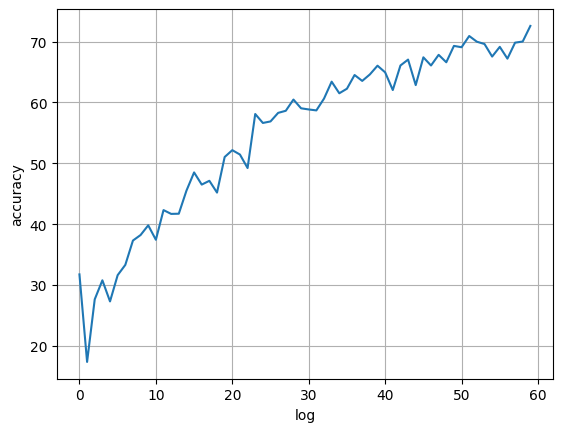

In [ ]:
import torchvision.models as models

tell_time = Timer()
iter_time = 0

vgg19 = vgg19.cuda() # VGG19 모델 instance를 생성
criterion = nn.CrossEntropyLoss() # cross entrophy loss 함수 정의
optimizer = torch.optim.Adam(vgg19.parameters(), lr=learning_rate) # 학습할 모델의 parameter와 learning rate를 인자로 주어 optimizer 정의

accuracy_list = []
for epoch in range(num_epochs):
    vgg19.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        outputs = vgg19(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, iter_time: %2.2f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item(), tell_time.toc()-iter_time))
            iter_time = tell_time.toc()
            accuracy_list = test_on_cifar10(vgg19, accuracy_list)

    acc_plot(accuracy_list)

## Pre-trained VGGNet fine-tuning 하기

> 사전 학습된 VGGNet을 불러와서 테스트를 해본다. \
> 양질의 데이터를 통해 학습되어 있는 모델의 정보를 직접 학습하지 않고 사용할 수 있게 되어서, 효율적으로 classification 성능 향상을 할 수 있다. \
> torchvision 라이브러리에 내장되어 있는 사전 학습된 VGGNet을을 이용한다.
> 이 VGGNet
은 1,000개의 클래스를 가지는 ImageNet 데이터셋으로 학습되어 있기 때문에, 마지막 MLP레이어를 CIFAR10에 맞게 새로 정의한 후 fine-tuning 한다.

> torchvision library를 이용하여 사전 학습된 VGGNet을 정의한다.

In [ ]:
# Pre-trained VGG19 모델 정의
import torchvision.models as models
pre_vgg = models.vgg19_bn(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:07<00:00, 73.1MB/s]


> 사전 학습된 모델이 1,000개의 클래스 중 하나를 예측하는 모델이므로, 마지막 MLP레이어를 10개의 클래스를 예측하도록 새로 정의한다.

In [ ]:
def explore_model(model, depth=0):
    if isinstance(model, torch.nn.Module):
        for name, child in model.named_children():
            if name != 'avgpool':
              print("  " * depth + f"└─ {name}: {child.__class__.__name__}")
              explore_model(child, depth + 1)

print("\n전체 pre_vgg 모델 구조:")
explore_model(pre_vgg)


전체 pre_vgg 모델 구조:
└─ features: Sequential
  └─ 0: Conv2d
  └─ 1: BatchNorm2d
  └─ 2: ReLU
  └─ 3: Conv2d
  └─ 4: BatchNorm2d
  └─ 5: ReLU
  └─ 6: MaxPool2d
  └─ 7: Conv2d
  └─ 8: BatchNorm2d
  └─ 9: ReLU
  └─ 10: Conv2d
  └─ 11: BatchNorm2d
  └─ 12: ReLU
  └─ 13: MaxPool2d
  └─ 14: Conv2d
  └─ 15: BatchNorm2d
  └─ 16: ReLU
  └─ 17: Conv2d
  └─ 18: BatchNorm2d
  └─ 19: ReLU
  └─ 20: Conv2d
  └─ 21: BatchNorm2d
  └─ 22: ReLU
  └─ 23: Conv2d
  └─ 24: BatchNorm2d
  └─ 25: ReLU
  └─ 26: MaxPool2d
  └─ 27: Conv2d
  └─ 28: BatchNorm2d
  └─ 29: ReLU
  └─ 30: Conv2d
  └─ 31: BatchNorm2d
  └─ 32: ReLU
  └─ 33: Conv2d
  └─ 34: BatchNorm2d
  └─ 35: ReLU
  └─ 36: Conv2d
  └─ 37: BatchNorm2d
  └─ 38: ReLU
  └─ 39: MaxPool2d
  └─ 40: Conv2d
  └─ 41: BatchNorm2d
  └─ 42: ReLU
  └─ 43: Conv2d
  └─ 44: BatchNorm2d
  └─ 45: ReLU
  └─ 46: Conv2d
  └─ 47: BatchNorm2d
  └─ 48: ReLU
  └─ 49: Conv2d
  └─ 50: BatchNorm2d
  └─ 51: ReLU
  └─ 52: MaxPool2d
└─ classifier: Sequential
  └─ 0: Linear
  └─ 1: ReLU
  

In [ ]:
class pretrained_vgg(nn.Module):
    def __init__(self, pre_vgg):
        super(pretrained_vgg, self).__init__()
        self.features = nn.Sequential(
            *list(pre_vgg.features.children())
        )
        # Pre-trained VGG19 모델의 fully connected layer만 CIFAR10 데이터에 맞게 변경

        self.linear = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    def forward(self, x):
        out = self.features(x).squeeze()
        out = self.linear(out)
        return out

> 모델, 목적함수, 최적화 모듈을 정의한다.

In [ ]:
vgg19 = pretrained_vgg(pre_vgg)
vgg19 = vgg19.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg19.parameters(), lr=learning_rate)

> 정해놓은 에폭 수만큼 fine-tuning한다.

<ipython-input-45-d045502740c8>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).cuda()
<ipython-input-45-d045502740c8>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).cuda()


Epoch [1/4], Iter [100/1562] Loss: 1.2446, iter_time: 3.07


<ipython-input-38-31abd6431de5>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images).cuda()


Test Accuracy of the model on the 100 test images: 57 %
Epoch [1/4], Iter [200/1562] Loss: 0.7215, iter_time: 4.15
Test Accuracy of the model on the 100 test images: 69 %
Epoch [1/4], Iter [300/1562] Loss: 0.8482, iter_time: 4.17
Test Accuracy of the model on the 100 test images: 75 %
Epoch [1/4], Iter [400/1562] Loss: 0.8900, iter_time: 4.95
Test Accuracy of the model on the 100 test images: 64 %
Epoch [1/4], Iter [500/1562] Loss: 0.3803, iter_time: 4.19
Test Accuracy of the model on the 100 test images: 77 %
Epoch [1/4], Iter [600/1562] Loss: 0.3901, iter_time: 4.19
Test Accuracy of the model on the 100 test images: 76 %
Epoch [1/4], Iter [700/1562] Loss: 0.6518, iter_time: 4.41
Test Accuracy of the model on the 100 test images: 78 %
Epoch [1/4], Iter [800/1562] Loss: 0.7371, iter_time: 4.20
Test Accuracy of the model on the 100 test images: 77 %
Epoch [1/4], Iter [900/1562] Loss: 0.8361, iter_time: 4.20
Test Accuracy of the model on the 100 test images: 79 %
Epoch [1/4], Iter [1000/

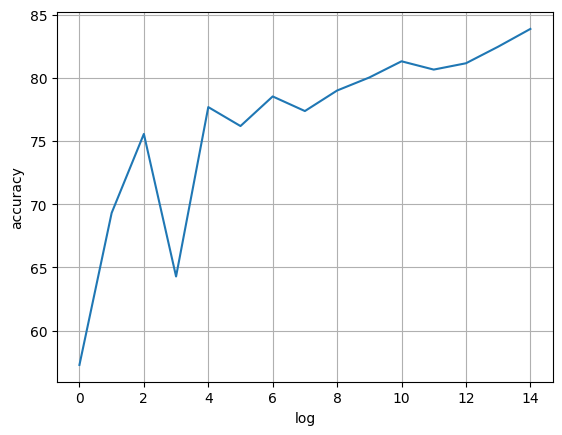

Epoch [2/4], Iter [100/1562] Loss: 0.4915, iter_time: 6.59
Test Accuracy of the model on the 100 test images: 85 %
Epoch [2/4], Iter [200/1562] Loss: 0.3585, iter_time: 4.17
Test Accuracy of the model on the 100 test images: 78 %
Epoch [2/4], Iter [300/1562] Loss: 0.5013, iter_time: 4.31
Test Accuracy of the model on the 100 test images: 84 %
Epoch [2/4], Iter [400/1562] Loss: 0.4669, iter_time: 4.16
Test Accuracy of the model on the 100 test images: 83 %
Epoch [2/4], Iter [500/1562] Loss: 0.2816, iter_time: 4.16
Test Accuracy of the model on the 100 test images: 83 %
Epoch [2/4], Iter [600/1562] Loss: 0.3893, iter_time: 4.21
Test Accuracy of the model on the 100 test images: 83 %
Epoch [2/4], Iter [700/1562] Loss: 0.0696, iter_time: 4.16
Test Accuracy of the model on the 100 test images: 84 %
Epoch [2/4], Iter [800/1562] Loss: 0.3560, iter_time: 4.17
Test Accuracy of the model on the 100 test images: 85 %
Epoch [2/4], Iter [900/1562] Loss: 0.6816, iter_time: 4.17
Test Accuracy of the 

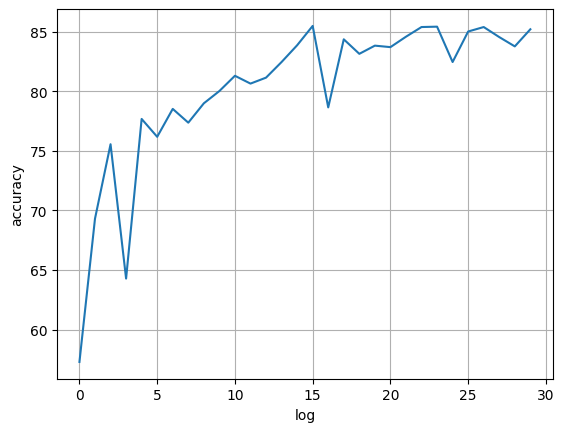

Epoch [3/4], Iter [100/1562] Loss: 0.2667, iter_time: 6.26
Test Accuracy of the model on the 100 test images: 88 %
Epoch [3/4], Iter [200/1562] Loss: 0.5519, iter_time: 4.32
Test Accuracy of the model on the 100 test images: 84 %
Epoch [3/4], Iter [300/1562] Loss: 0.5654, iter_time: 4.17
Test Accuracy of the model on the 100 test images: 84 %
Epoch [3/4], Iter [400/1562] Loss: 0.0896, iter_time: 4.18
Test Accuracy of the model on the 100 test images: 86 %
Epoch [3/4], Iter [500/1562] Loss: 0.4053, iter_time: 4.21
Test Accuracy of the model on the 100 test images: 85 %
Epoch [3/4], Iter [600/1562] Loss: 0.3370, iter_time: 4.18
Test Accuracy of the model on the 100 test images: 87 %


KeyboardInterrupt: 

In [ ]:
tell_time = Timer()
iter_time = 0

accuracy_list = []
for epoch in range(num_epochs):
    vgg19.train()
    for i, (images, labels) in enumerate(train_loader):
        images = torch.tensor(images).cuda()
        labels = torch.tensor(labels).cuda()

        optimizer.zero_grad()
        outputs = vgg19(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, iter_time: %2.2f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.item(), tell_time.toc()-iter_time))
            iter_time = tell_time.toc()
            accuracy_list = test_on_cifar10(vgg19, accuracy_list)

    acc_plot(accuracy_list)